# Objects, Scene and Activity Detection using Amazon Rekognition

***
This notebook provides a walkthrough of [object detection API](https://docs.aws.amazon.com/rekognition/latest/dg/labels.html) in Amazon Rekognition. You can quickly identify objects in your video and image libraries to catalog footage and photos for marketing, advertising, and media industry use cases.
***

# Initialize stuff

In [1]:
# Initialise Notebook
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import time
import os

In [2]:
# Curent AWS Region. Use this to choose corresponding S3 bucket with sample content

mySession = boto3.session.Session()
awsRegion = mySession.region_name

In [3]:
# Init clients
rekognition = boto3.client('rekognition')
s3 = boto3.client('s3')

In [4]:
# S3 bucket that contains sample images and videos

# We are providing sample images and videos in this bucket so
# you do not have to manually download/upload test images and videos.

bucketName = "aws-workshops-" + awsRegion

In [5]:
# Create temporary directory
# This directory is not needed to call Rekognition APIs.
# We will only use this directory to download images from S3 bucket and drwaw bounding boxes
# around recognized celebrities to show them here in the notebook.

!mkdir m1tmp
tempFolder = 'm1tmp/'

# Detect objects in image
***

In [6]:
imageName = "object-detection/skateboard.jpg"

In [7]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': imageName})))

#### Call Rekognition to detect objects in the image

In [8]:
# Call Amazon Rekognition to detect objects in the image
# https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectLabels.html

detectLabelsResponse = rekognition.detect_labels(
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    }
)

#### Review the raw JSON reponse from Rekognition

In [9]:
# Show JSON response returned by Rekognition Labels API (Object Detection)
# In the JSON response below, you will see Label, detected instances, confidence score and additional information.

display(detectLabelsResponse)

{'Labels': [{'Name': 'Car',
   'Confidence': 99.15271759033203,
   'Instances': [{'BoundingBox': {'Width': 0.10616336017847061,
      'Height': 0.18528179824352264,
      'Left': 0.0037978808395564556,
      'Top': 0.5039216876029968},
     'Confidence': 99.15271759033203},
    {'BoundingBox': {'Width': 0.2429988533258438,
      'Height': 0.21577216684818268,
      'Left': 0.7309805154800415,
      'Top': 0.5251884460449219},
     'Confidence': 99.1286392211914},
    {'BoundingBox': {'Width': 0.14233611524105072,
      'Height': 0.15528248250484467,
      'Left': 0.6494812965393066,
      'Top': 0.5333095788955688},
     'Confidence': 98.48368072509766},
    {'BoundingBox': {'Width': 0.11086395382881165,
      'Height': 0.10271988064050674,
      'Left': 0.10355594009160995,
      'Top': 0.5354844927787781},
     'Confidence': 96.45606231689453},
    {'BoundingBox': {'Width': 0.06254628300666809,
      'Height': 0.053911514580249786,
      'Left': 0.46083059906959534,
      'Top': 0.55

#### Display list of detected objects

In [10]:
for label in detectLabelsResponse["Labels"]:
    print("- {} (Confidence: {})".format(label["Name"], label["Confidence"]))
    print("  - Parents: {}".format(label["Parents"]))
    print("  - Instances: {}".format(len(label["Instances"])))

- Car (Confidence: 99.15271759033203)
  - Parents: [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]
  - Instances: 14
- Transportation (Confidence: 99.15271759033203)
  - Parents: []
  - Instances: 0
- Automobile (Confidence: 99.15271759033203)
  - Parents: [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]
  - Instances: 0
- Vehicle (Confidence: 99.15271759033203)
  - Parents: [{'Name': 'Transportation'}]
  - Instances: 0
- Person (Confidence: 98.9914321899414)
  - Parents: []
  - Instances: 2
- Human (Confidence: 98.9914321899414)
  - Parents: []
  - Instances: 0
- Wheel (Confidence: 93.24951934814453)
  - Parents: [{'Name': 'Machine'}]
  - Instances: 10
- Machine (Confidence: 93.24951934814453)
  - Parents: []
  - Instances: 0
- Road (Confidence: 92.61514282226562)
  - Parents: []
  - Instances: 0
- Sport (Confidence: 92.37877655029297)
  - Parents: [{'Name': 'Person'}]
  - Instances: 0
- Skateboard (Confidence: 92.37877655029297)
  - Parents: [{'Name': 'Sport'}, {'Name': 'Person'}]

#### Show image with bounding boxes around detected objects

In [11]:
# Define a function that will display image with bounded boxes around recognized celebrites
# We will call this function in next step
  
def drawBoundingBoxes (sourceImage, boxes):
    # blue, green, red, grey
    colors = ((255,255,255),(255,255,255),(76,182,252),(52,194,123))
    
    # Download image locally
    imageLocation = tempFolder+os.path.basename(sourceImage)
    s3.download_file(bucketName, sourceImage, imageLocation)

    # Draws BB on Image
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size
    col = 0
    maxcol = len(colors)
    line= 3
    for box in boxes:
        x1 = int(box[1]['Left'] * width)
        y1 = int(box[1]['Top'] * height)
        x2 = int(box[1]['Left'] * width + box[1]['Width'] * width)
        y2 = int(box[1]['Top'] * height + box[1]['Height']  * height)
        
        draw.text((x1,y1),box[0],colors[col])
        for l in range(line):
            draw.rectangle((x1-l,y1-l,x2+l,y2+l),outline=colors[col])
        col = (col+1)%maxcol
    
    imageFormat = "PNG"
    ext = sourceImage.lower()
    if(ext.endswith('jpg') or ext.endswith('jpeg')):
       imageFormat = 'JPEG'

    bbImage.save(imageLocation,format=imageFormat)

    display(bbImage)

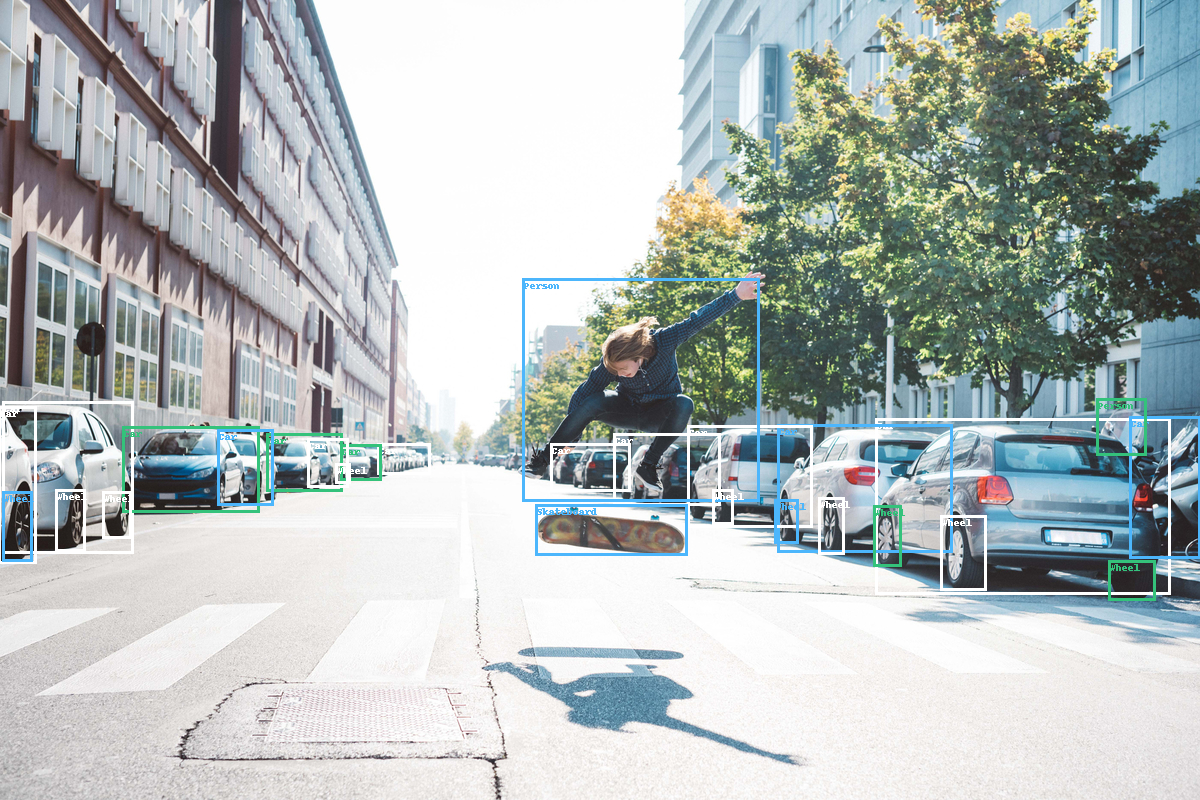

In [12]:
# Extract bounding box information from JSON response above and display image with bounding boxes around objects.

boxes = []
objects = detectLabelsResponse['Labels']
for obj in objects:
    for einstance in obj["Instances"]:
        boxes.append ((obj['Name'], einstance['BoundingBox']))
    
drawBoundingBoxes(imageName, boxes)

# Recognize objects in video
 Object recognition in video is an async operation. 
https://docs.aws.amazon.com/rekognition/latest/dg/API_StartLabelDetection.html
 We first start label detection job which returns a Job Id.
 We can then call get_label_detection to get the job status and after job is complete, we can get 
 object metadata.
 In production use cases, you would usually use StepFucntion or SNS topic to get notified when job is complete.
***

In [13]:
videoName = "celebrity-rekognition/media/GrandTour720.mp4"

#### Call Rekognition to start a job for object detection

In [14]:
# Start celebrity recognition job
startLabelDetection = rekognition.start_label_detection(
    Video={
        'S3Object': {
            'Bucket': bucketName,
            'Name': videoName,
        }
    },
)

labelsJobId = startLabelDetection['JobId']
display("Job Id: {0}".format(labelsJobId))

'Job Id: b3c5e85a8c582f8ae0905d4399ee52526a882be1d295184ee859b006fc2e6574'

### Additional (Optional) Request Attributes

ClientRequestTokenL
https://docs.aws.amazon.com/rekognition/latest/dg/API_StartLabelDetection.html#rekognition-StartLabelDetection-request-ClientRequestToken

JobTag:
https://docs.aws.amazon.com/rekognition/latest/dg/API_StartLabelDetection.html#rekognition-StartLabelDetection-request-JobTag

MinConfidence:
https://docs.aws.amazon.com/rekognition/latest/dg/API_StartLabelDetection.html#rekognition-StartLabelDetection-request-MinConfidence

NotificationChannel:
https://docs.aws.amazon.com/rekognition/latest/dg/API_StartLabelDetection.html#rekognition-StartLabelDetection-request-NotificationChannel


#### Wait for object detection job to complete

In [15]:
# Wait for object detection job to complete
# In production use cases, you would usually use StepFucntion or SNS topic to get notified when job is complete.
getObjectDetection = rekognition.get_label_detection(
    JobId=labelsJobId,
    SortBy='TIMESTAMP'
)

while(getObjectDetection['JobStatus'] == 'IN_PROGRESS'):
    time.sleep(5)
    print('.', end='')
 
    getObjectDetection = rekognition.get_label_detection(
    JobId=labelsJobId,
    SortBy='TIMESTAMP')
    
display(getObjectDetection['JobStatus'])

'SUCCEEDED'

#### Review raw JSON reponse from Rekognition

In [16]:
# Show JSON response returned by Rekognition Object Detection API
# In the JSON response below, you will see list of detected objects and activities.
# For each detected object, you will see information like Timestamp

display(getObjectDetection)

{'JobStatus': 'SUCCEEDED',
 'VideoMetadata': {'Codec': 'h264',
  'DurationMillis': 15015,
  'Format': 'QuickTime / MOV',
  'FrameRate': 23.976024627685547,
  'FrameHeight': 720,
  'FrameWidth': 1280},
 'Labels': [{'Timestamp': 0,
   'Label': {'Name': 'Gray',
    'Confidence': 64.29531860351562,
    'Instances': [],
    'Parents': []}},
  {'Timestamp': 458,
   'Label': {'Name': 'Alloy Wheel',
    'Confidence': 79.14044952392578,
    'Instances': [],
    'Parents': [{'Name': 'Spoke'}, {'Name': 'Wheel'}, {'Name': 'Machine'}]}},
  {'Timestamp': 458,
   'Label': {'Name': 'Automobile',
    'Confidence': 86.4385986328125,
    'Instances': [],
    'Parents': [{'Name': 'Transportation'}, {'Name': 'Vehicle'}]}},
  {'Timestamp': 458,
   'Label': {'Name': 'Car',
    'Confidence': 86.4385986328125,
    'Instances': [{'BoundingBox': {'Width': 0.24835073947906494,
       'Height': 0.1753828227519989,
       'Left': 0.18209484219551086,
       'Top': 0.553619921207428},
      'Confidence': 99.89363098

#### Dislpay names of recognized objects in the video

In [17]:
theObjects = {}

# Display timestamps and celebrites detected at that time
strDetail = "Objects detected in video<br>=======================================<br>"
strOverall = "Objects in the overall video:<br>=======================================<br>"

# Celebrities detected in each frame
for obj in getObjectDetection['Labels']:
    ts = obj ["Timestamp"]
    cconfidence = obj['Label']["Confidence"]
    oname = obj['Label']["Name"]
    strDetail = strDetail + "At {} ms: {} (Confidence: {})<br>".format(ts, oname, round(cconfidence,2))
    if oname in theObjects:
        cojb = theObjects[oname]
        theObjects[oname] = {"Name" : oname, "Count": 1+cojb["Count"]}
    else:
        theObjects[oname] = {"Name" : oname, "Count": 1}

# Unique objects detected in video
for theObject in theObjects:
    strOverall = strOverall + "Name: {}, Count: {}<br>".format(theObject, theObjects[theObject]["Count"])

# Display results
display(HTML(strOverall))
#display(HTML(strDetail))

#### Show video in the player

In [18]:
# Show video in a player

s3FilePrefix = "https://s3.amazonaws.com"
if(not awsRegion == 'us-east-1'):
    s3FilePrefix = "https://s3-{}.amazonaws.com".format(awsRegion)

s3VideoUrl = "{0}/{1}/{2}".format(s3FilePrefix, bucketName, videoName)

videoTag = "<video controls='controls' autoplay width='640' height='360' name='Video' src='{0}'></video>".format(s3VideoUrl)

videoui = "<table><tr><td style='vertical-align: top'>{}</td></tr></table>".format(videoTag)

display(HTML(videoui))

""


In [19]:
listui = "<table><tr><td style='vertical-align: top'>{}</td></tr></table>".format(strDetail)
display(HTML(listui))

## Overlapping objects in Images
***

In [20]:
# Now let us try an image with non-celebtiries in the image.

imageName = "object-detection/hat-detection.png"

In [21]:
# Call Amazon Rekognition to detect objects in the image

detectLabelsResponse = rekognition.detect_labels(
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    }
)

In [22]:
# Display Rekognition response
# You will see Rekognition return an empty list for CelebrityFaces and 
# UnrecognizedFaces list with unrecognized faces that were detected in the image.
# In the next module you will learn how to get custom-celebrity faces recognized.

display(detectLabelsResponse)

{'Labels': [{'Name': 'Human',
   'Confidence': 99.74844360351562,
   'Instances': [],
   'Parents': []},
  {'Name': 'Person',
   'Confidence': 99.74844360351562,
   'Instances': [{'BoundingBox': {'Width': 0.46602997183799744,
      'Height': 0.9347332715988159,
      'Left': 0.3739253580570221,
      'Top': 0.020740503445267677},
     'Confidence': 99.74844360351562},
    {'BoundingBox': {'Width': 0.1087615117430687,
      'Height': 0.19702018797397614,
      'Left': 0.8208402395248413,
      'Top': 0.027133075520396233},
     'Confidence': 99.04203033447266}],
   'Parents': []},
  {'Name': 'Apparel',
   'Confidence': 88.69605255126953,
   'Instances': [],
   'Parents': []},
  {'Name': 'Clothing',
   'Confidence': 88.69605255126953,
   'Instances': [],
   'Parents': []},
  {'Name': 'Helmet',
   'Confidence': 85.29509735107422,
   'Instances': [{'BoundingBox': {'Width': 0.13620616495609283,
      'Height': 0.15723171830177307,
      'Left': 0.5521214604377747,
      'Top': 0.01142940297

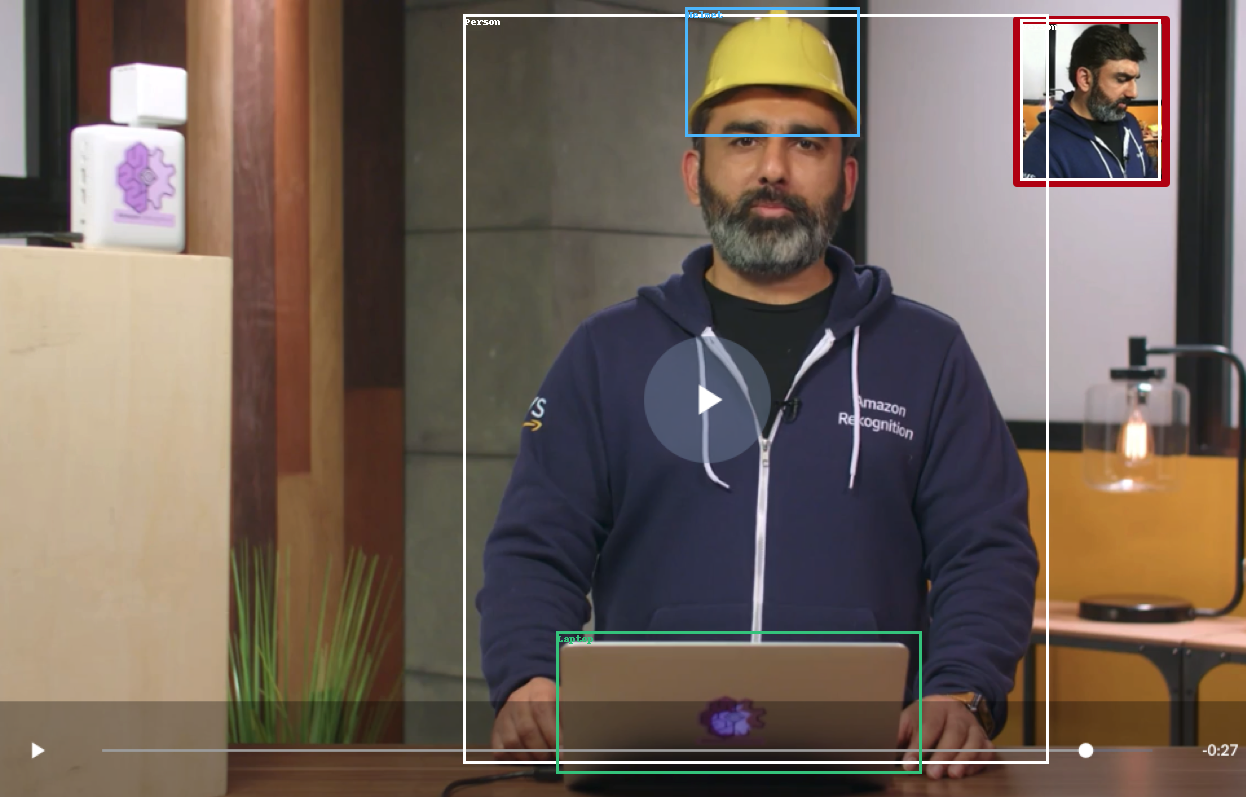

In [23]:
#Show image and bounded boxes around detected faces

boxes = []
objects = detectLabelsResponse['Labels']
for obj in objects:
    for einstance in obj["Instances"]:
        boxes.append ((obj['Name'], einstance['BoundingBox']))
    
drawBoundingBoxes(imageName, boxes)


In [24]:
def matchPersonsAndHats(personsList, hardhatsList):

    persons = []
    hardhats = []
    personsWithHats = []

    for person in personsList:
        persons.append(person)
    for hardhat in hardhatsList:
        hardhats.append(hardhat)

    h = 0
    matched = 0
    totalHats = len(hardhats)
    while(h < totalHats):
        hardhat = hardhats[h-matched]
        totalPersons = len(persons)
        p = 0
        while(p < totalPersons):
            person = persons[p]
            if(not (hardhat['BoundingBoxCoordinates']['x2'] < person['BoundingBoxCoordinates']['x1']
                or hardhat['BoundingBoxCoordinates']['x1'] > person['BoundingBoxCoordinates']['x2']
                or hardhat['BoundingBoxCoordinates']['y4'] < person['BoundingBoxCoordinates']['y1']
                    or hardhat['BoundingBoxCoordinates']['y1'] > person['BoundingBoxCoordinates']['y4']
                )):

                personsWithHats.append({'Person' : person, 'Hardhat' : hardhat})

                del persons[p]
                del hardhats[h - matched]

                matched = matched + 1

                break
            p = p + 1
        h = h + 1

    return (personsWithHats, persons, hardhats)

def getBoundingBoxCoordinates(boundingBox, imageWidth, imageHeight):
    x1 = 0
    y1 = 0
    x2 = 0
    y2 = 0
    x3 = 0
    y3 = 0
    x4 = 0
    y4 = 0

    boxWidth = boundingBox['Width']*imageWidth
    boxHeight = boundingBox['Height']*imageHeight

    x1 = boundingBox['Left']*imageWidth
    y1 = boundingBox['Top']*imageWidth

    x2 = x1 + boxWidth
    y2 = y1

    x3 = x2
    y3 = y1 + boxHeight

    x4 = x1
    y4 = y3

    return({'x1': x1, 'y1' : y1, 'x2' : x2, 'y2' : y2, 'x3' : x3, 'y3' : y3, 'x4' : x4, 'y4' : y4})

def getPersonsAndHardhats(labelsResponse, imageWidth, imageHeight):

    persons = []
    hardhats = []

    for label in labelsResponse['Labels']:
        if label['Name'] == 'Person' and 'Instances' in label:
            for person in label['Instances']:
                    persons.append({'BoundingBox' : person['BoundingBox'], 'BoundingBoxCoordinates' : getBoundingBoxCoordinates(person['BoundingBox'], imageWidth, imageHeight), 'Confidence' : person['Confidence']})
        elif ((label['Name'] == 'Hardhat' or label['Name'] == 'Helmet') and 'Instances' in label):
            for hardhat in label['Instances']:
                hardhats.append({'BoundingBox' : hardhat['BoundingBox'], 'BoundingBoxCoordinates' : getBoundingBoxCoordinates(hardhat['BoundingBox'], imageWidth, imageHeight), 'Confidence' : hardhat['Confidence']})

    return (persons, hardhats)

In [25]:
s3Resource = boto3.resource('s3')
bucket = s3Resource.Bucket(bucketName)
iojb = bucket.Object(imageName)
response = iojb.get()
file_stream = response['Body']
im = Image.open(file_stream)
imageWidth, imageHeight = im.size


In [26]:
persons, hardhats = getPersonsAndHardhats(detectLabelsResponse, imageWidth, imageHeight)

personsWithHats, personsWithoutHats, hatsWihoutPerson = matchPersonsAndHats(persons, hardhats)

personsWithHatsCount = len(personsWithHats)
personsWithoutHatsCount = len(personsWithoutHats)
hatsWihoutPersonCount = len(hatsWihoutPerson)

outputMessage = "Person(s): {}".format(personsWithHatsCount+personsWithoutHatsCount)
outputMessage = outputMessage + "\nPerson(s) With Safety Hat: {}\nPerson(s) Without Safety Hat: {}".format(personsWithHatsCount, personsWithoutHatsCount)
print(outputMessage)

Person(s): 2
Person(s) With Safety Hat: 1
Person(s) Without Safety Hat: 1


***
### References
- https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectLabels.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_StartLabelDetection.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_GetLabelDetection.html

***

You have successfully used Amazon Rekognition to identify celebrities in images an videos. In the next module, Recognize Custom Celebrities, you will learn how to recognize your custom celebrities in the images and videos.